In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import random
import librosa
from scipy.io import wavfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

In [18]:
epochs = 60
batch_size = 8
learning_rate = 0.0000075
device_cpu = torch.device('cpu')
device=torch.device("cuda:0")
root = "/home/dl/yufeng/mels/"

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

train = pd.read_csv('/home/dl/yufeng/trainV3.csv')
val = pd.read_csv('/home/dl/yufeng/trainV3.csv')

In [5]:
class MyDataSet(Dataset):
    def __init__(self, df_data, mode, data_dir, transform=None):
        super().__init__()
        self.df = df_data
        self.mode = mode
        self.data_dir = data_dir
        self.transform = transform
        self.data_list = list(df_data)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        if(self.mode == 'train'):
            vedio_name = self.df['vedio_name'][index]
            mel_name = vedio_name.split(".")[0]+".npy"
            label = self.df['real_or_fake'][index]
            part = self.df['part'][index]
            path = os.path.join(self.data_dir, str(part), mel_name)
            mel=np.load(path)
            if self.transform is not None:
                mel = mel[:,:400]
                mel = trans_train(mel)
            return mel, label

In [6]:
trans_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5], 
        [0.5])
])

In [7]:
dataset_train = MyDataSet(df_data=train, mode='train', transform=trans_train, data_dir=root)
dataset_valid = MyDataSet(df_data=val, mode='train', transform=trans_train, data_dir=root)
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=batch_size,shuffle=False, num_workers=8)

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(128*3, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.avg(x)
        x = x.view(-1, 128*3)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [9]:
class MASRCNN_activate(nn.Module):
    def __init__(self, max_sent_len, embedding_dim, num_conv_blocks, init_neurons, num_classes=2):
        super(MASRCNN_activate, self).__init__()
        num_dense_neurons = 50
        convnet_3 = []
        convnet_5 = []
        convnet_7 = []
        for ly in range(0, num_conv_blocks):
            if ly == 0:
                convnet_3.append(nn.Conv1d(in_channels=embedding_dim, out_channels=init_neurons, kernel_size=3))
                convnet_3.append(nn.LeakyReLU(0.2))
                convnet_5.append(nn.Conv1d(in_channels=embedding_dim, out_channels=init_neurons, kernel_size=5))
                convnet_5.append(nn.LeakyReLU(0.2))
                convnet_7.append(nn.Conv1d(in_channels=embedding_dim, out_channels=init_neurons, kernel_size=7))
                convnet_7.append(nn.LeakyReLU(0.2))
            elif ly == 1:
                convnet_3.append(nn.Conv1d(in_channels=init_neurons, out_channels=init_neurons*(ly*2), kernel_size=3))
                convnet_3.append(nn.LeakyReLU(0.2))
                convnet_5.append(nn.Conv1d(in_channels=init_neurons, out_channels=init_neurons*(ly*2), kernel_size=5))
                convnet_5.append(nn.LeakyReLU(0.2))
                convnet_7.append(nn.Conv1d(in_channels=init_neurons, out_channels=init_neurons*(ly*2), kernel_size=7))
                convnet_7.append(nn.LeakyReLU(0.2))
            else:
                convnet_3.append(nn.Conv1d(in_channels=init_neurons*((ly - 1)*2), out_channels=init_neurons*(ly*2), kernel_size=3))
                convnet_3.append(nn.LeakyReLU(0.2))
                convnet_5.append(nn.Conv1d(in_channels=init_neurons*((ly - 1)*2), out_channels=init_neurons*(ly*2), kernel_size=5))
                convnet_5.append(nn.LeakyReLU(0.2))
                convnet_7.append(nn.Conv1d(in_channels=init_neurons*((ly - 1)*2), out_channels=init_neurons*(ly*2), kernel_size=7))
                convnet_7.append(nn.LeakyReLU(0.2))
        self.conv_blocks_3 = nn.Sequential(*convnet_3)
        self.conv_blocks_5 = nn.Sequential(*convnet_5)
        self.conv_blocks_7 = nn.Sequential(*convnet_7)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.dense = nn.Sequential(nn.Linear(448*3, num_dense_neurons),
                                    nn.BatchNorm1d(num_dense_neurons),
                                    nn.LeakyReLU(0.2)
                                    )
        self.fc = nn.Linear(50, num_classes)
    
    def forward(self, x):
        x_3 = self.conv_blocks_3(x)
        x_5 = self.conv_blocks_5(x)
        x_7 = self.conv_blocks_7(x)
        x_3 = self.maxpool(x_3)
        x_5 = self.maxpool(x_5)
        x_7 = self.maxpool(x_7)
        x = torch.cat([x_3, x_5, x_7], 2)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        return x

In [10]:
model = SimpleNet().to(device)
# model = MASRCNN_activate.to(device)

In [11]:
criterion = nn.BCELoss(reduction="mean")
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [19]:
total_step = len(loader_train)
min_val_loss = np.inf
val_losses = []
for epoch in range(epochs):
    avg_loss = 0.0
    for i, (images, labels) in enumerate(loader_train):
        labels = labels.float()
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        
        loss.backward()
        optimizer.step()
#         if i%100==0:
#             print("batch "+str(i+1)+" finished.")
        
    for i,(images, labels) in enumerate(loader_valid):
        labels = labels.float()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / len(loader_valid)
    val_losses.append(avg_loss)
        
    print('epoch:[{}], valid_loss:[{}]'.format(epoch+1,avg_loss))

epoch:[1], valid_loss:[0.41219176820528186]
epoch:[2], valid_loss:[0.40830754385908596]
epoch:[3], valid_loss:[0.4067451468463055]
epoch:[4], valid_loss:[0.4062966569639532]
epoch:[5], valid_loss:[0.4045149333984275]
epoch:[6], valid_loss:[0.40596525135458045]
epoch:[7], valid_loss:[0.4089605194017273]
epoch:[8], valid_loss:[0.40554527841026233]
epoch:[9], valid_loss:[0.4061617256393509]
epoch:[10], valid_loss:[0.4033382581012441]
epoch:[11], valid_loss:[0.40312227165560793]
epoch:[12], valid_loss:[0.40306365598215993]
epoch:[13], valid_loss:[0.4056815594180013]
epoch:[14], valid_loss:[0.4062258372667795]
epoch:[15], valid_loss:[0.40745082433916563]
epoch:[16], valid_loss:[0.4076743753529145]
epoch:[17], valid_loss:[0.4006223562872893]
epoch:[18], valid_loss:[0.399384556845358]
epoch:[19], valid_loss:[0.401516983888234]
epoch:[20], valid_loss:[0.40084750933961544]
epoch:[21], valid_loss:[0.40007904471240524]
epoch:[22], valid_loss:[0.39867341706713466]
epoch:[23], valid_loss:[0.4011407

In [20]:
acc = 0
for i,(images, labels) in enumerate(loader_valid):
    labels = labels.float()
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    acc += torch.sum(outputs.squeeze().round()==labels)
acc = acc.to(device_cpu)
accuracy = acc.numpy()/float(len(dataset_valid))
print("Acc:  " + str(accuracy))

Acc:  0.8078156006716531


In [21]:
print(acc)
print(len(dataset_valid))

tensor(5292)
6551


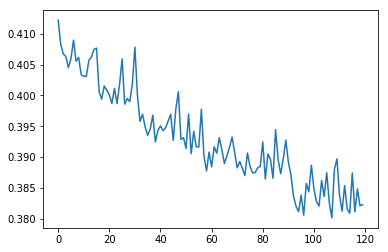

In [22]:
import matplotlib.pyplot as plt
plt.plot(val_losses)

In [16]:
# flags = list(val['real_or_fake'])
# real_cnt = 0
# fake_cnt = 0

# for flag in flags:
#     if flag == 1:
#         real_cnt = real_cnt + 1
#     elif flag == 0:
#         fake_cnt = fake_cnt + 1

In [17]:
# print(real_cnt)
# print(fake_cnt)